<a href="https://colab.research.google.com/github/rosehelfrich/Ky_School_data/blob/main/Predict_Classification%2C_Most_Impacted%2C_and_Summarize_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Column / Row options
pd.options.display.max_columns = None
pd.options.display.max_rows = 20

# Two decimal places and the thousands separator
pd.options.display.float_format = '{:,.2f}'.format

# Merge scores with KY df

In [4]:
df_scores = pd.read_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/df_scores.csv')

In [5]:
ky_spending_df = pd.read_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/published_ky_df_all.csv')

In [6]:
ky_spending_df = ky_spending_df.loc[:,['End Year', 'School Code', 'Reported Spending per student', 'Money Difference per school',
       'Money Difference per student', 'Estimated Spending per student']]

In [7]:
df = pd.merge(df_scores, ky_spending_df, on=['End Year', 'School Code'], how='left')

In [8]:
df.drop_duplicates(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

df.index

RangeIndex(start=0, stop=9892, step=1)

In [9]:
columns_df = ['End Year', 'District Code', 'School Code', 'Proficiency Rate', 
              'Reported Spending per student', 'Money Difference per school', 
              'Money Difference per student', 'Estimated Spending per student']

for column in columns_df:
  df = df.round({column:0})
  df[column] = df[column].astype(int, errors='ignore')

In [10]:
df

,End Year,District Code,District,School Code,School,Proficiency Rate,KY Rank/Rating,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
0,2012,1,Adair County,1010,Adair County High School,55,57,Needs Improvement,"6,457.00","-36,414.00",-52.00,"6,405.00"
1,2013,1,Adair County,1010,Adair County High School,54,48,Needs Improvement,"6,377.00","-37,044.00",-49.00,"6,328.00"
2,2014,1,Adair County,1010,Adair County High School,69,65,Needs Improvement/Progressing,"6,970.00","-13,146.00",-18.00,"6,952.00"
3,2015,1,Adair County,1010,Adair County High School,71,73,Proficient/Progressing,"9,486.00","-42,096.00",-55.00,"9,431.00"
4,2016,1,Adair County,1010,Adair County High School,72,Proficient/Progressing,NaN,"10,270.00","-19,228.00",-25.00,"10,245.00"
...,...,...,...,...,...,...,...,...,...,...,...,...
9887,2016,601,Woodford County,601120,Northside Elementary School,60,Needs Improvement,NaN,"12,046.00","34,017.00",107.00,"12,153.00"
9888,2017,601,Woodford County,601120,Northside Elementary School,75,NaN,NaN,"9,940.00","17,446.00",53.00,"9,993.00"
9889,2018,601,Woodford County,601120,Northside Elementary School,73,NaN,NaN,"13,641.00","51,768.00",150.00,"13,791.00"
9890,2019,601,Woodford County,601120,Northside Elementary School,76,High,NaN,"11,865.00","48,399.00",142.00,"12,007.00"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9892 entries, 0 to 9891
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        9892 non-null   int64  
 1   District Code                   9892 non-null   int64  
 2   District                        9892 non-null   object 
 3   School Code                     9892 non-null   int64  
 4   School                          9892 non-null   object 
 5   Proficiency Rate                9892 non-null   int64  
 6   KY Rank/Rating                  7673 non-null   object 
 7   Classification                  4309 non-null   object 
 8   Reported Spending per student   8637 non-null   float64
 9   Money Difference per school     8637 non-null   float64
 10  Money Difference per student    8637 non-null   float64
 11  Estimated Spending per student  8637 non-null   float64
dtypes: float64(4), int64(4), object(4)

# Predict classification 

In [12]:
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
predict_df = df.copy()

In [14]:
# Use replace to take out "/Progressing"
predict_df.replace('Distinguished/Progressing', 'Distinguished', inplace=True)
predict_df.replace('Proficient/Progressing', 'Proficient', inplace=True)
predict_df.replace('Needs Improvement/Progressing', 'Needs Improvement', inplace=True)


# In the Ky Rank column, make this common language.
predict_df.replace('Very High', 'Distinguished', inplace=True)
predict_df.replace('High', 'Distinguished', inplace=True)
predict_df.replace('Medium', 'Proficient', inplace=True)
predict_df.replace('Low', 'Needs Improvement', inplace=True)
predict_df.replace('Very Low', 'Needs Improvement', inplace=True)

In [15]:
predict_df['Proficiency Rate'] = predict_df['Proficiency Rate'].astype(int)

In [16]:
# Modify the Ky Rank / Rating column so that it contains only number values
# Put the string values into the Classification column 
for i in predict_df.index:
  if predict_df['KY Rank/Rating'][i] == 'Distinguished':
    predict_df.at[i,'Classification'] = str('Distinguished')
  elif predict_df['KY Rank/Rating'][i] == 'Proficient':
    predict_df.at[i,'Classification'] = str('Proficient')
  elif predict_df['KY Rank/Rating'][i] == 'Needs Improvement':
    predict_df.at[i,'Classification'] = str('Needs Improvement')


In [17]:
predict_df.drop(['KY Rank/Rating'], axis=1, inplace=True)

In [18]:
predict_df = predict_df.round({'Reported Spending per student': -1, 'Money Difference per school': -2, 
                               'Money Difference per student':-1, 'Estimated Spending per student': 1})

In [19]:
unscaled_df = predict_df.copy()

In [20]:
unscaled_df.drop(['District', 'District Code', 'School Code', 'School', 'Money Difference per student', 
                  'Estimated Spending per student'], axis=1, inplace=True)

In [21]:
unscaled_df.dropna(inplace=True) #here
unscaled_df.reset_index(drop=True, inplace=True)

In [22]:
# Reorder columns

unscaled_df = unscaled_df[['End Year', 'Proficiency Rate', 'Reported Spending per student', 'Money Difference per school', 'Classification']]

In [23]:
unscaled_df['Classification'] = unscaled_df['Classification'].map({'Distinguished': 0, 'Proficient':1, 'Needs Improvement':2})

In [24]:
unscaled_df[['End Year', 'Proficiency Rate', 'Reported Spending per student', 'Money Difference per school', 'Classification']]

,End Year,Proficiency Rate,Reported Spending per student,Money Difference per school,Classification
0,2012,55,"6,460.00","-36,400.00",2
1,2013,54,"6,380.00","-37,000.00",2
2,2014,69,"6,970.00","-13,100.00",2
3,2015,71,"9,490.00","-42,100.00",1
4,2016,72,"10,270.00","-19,200.00",1
...,...,...,...,...,...
6414,2013,63,"11,970.00","66,200.00",1
6415,2014,71,"11,210.00","43,600.00",1
6416,2015,70,"12,260.00","33,000.00",1
6417,2016,60,"12,050.00","34,000.00",2


In [25]:
unscaled_columns = ['End Year', 'Proficiency Rate', 'Classification',
       'Reported Spending per student', 'Money Difference per school']

for column in unscaled_df.columns:
  unscaled_df[column] = unscaled_df[column].astype(np.float32)

## Shuffle, Balance, Split, Scale

In [26]:
#Shuffle df
unscaled_df = unscaled_df.sample(frac=1, random_state=15)

# Save indices
shuffled_indices = unscaled_df.index

In [27]:
unscaled_df['Classification'].value_counts()

2.00    3195
1.00    1667
0.00    1557
Name: Classification, dtype: int64

In [28]:
# Balance the data
balanced_df = unscaled_df.iloc[0:0]

for i in unscaled_df['Classification'].unique():   #unscaled_df.index:
  min_target_size = unscaled_df['Classification'].value_counts().min()
  #value_target = unscaled_df['Classification'][i]
  target_values = unscaled_df[unscaled_df['Classification']==i]  #value_target]
  fraction = round(min_target_size / target_values.shape[0], 2)
  sample_data = target_values.sample(frac=fraction, random_state=8)
  balanced_df = pd.concat([balanced_df, sample_data])

# Shuffle the data
balanced_df = balanced_df.sample(frac=1, random_state=3)

In [29]:
# Just in case we need the indices later. 

shuffled_indices = balanced_df.index

In [30]:
balanced_df['Classification'].value_counts()

2.00    1566
0.00    1557
1.00    1550
Name: Classification, dtype: int64

In [31]:
balanced_df[balanced_df.isnull().any(axis=1)]

,End Year,Proficiency Rate,Reported Spending per student,Money Difference per school,Classification


In [32]:
unscaled_inputs = balanced_df.values[:,:-1]

In [33]:
targets = balanced_df.values[:,-1]

In [34]:
# Split into training, validation, and test sets

unscaled_X_train, unscaled_X_set, y_train, y_set = train_test_split(unscaled_inputs, targets, test_size=0.2, random_state=15)
unscaled_X_valid, unscaled_X_test, y_valid, y_test = train_test_split(unscaled_X_set, y_set, test_size=0.5, random_state=13)

In [35]:
# Scale data

epsb_scaler = StandardScaler()

# Calculate and store the mean and sd
epsb_scaler.fit(unscaled_X_train)

# Apply the scaler
scaled_X_train = epsb_scaler.transform(unscaled_X_train)
scaled_X_valid = epsb_scaler.transform(unscaled_X_valid)
scaled_X_test = epsb_scaler.transform(unscaled_X_test)

In [36]:
scaled_X_train.shape

(3738, 4)

In [37]:
y_train

array([2., 1., 0., ..., 1., 2., 0.], dtype=float32)

In [38]:
scaled_X_valid.shape

(467, 4)

In [39]:
y_valid.shape

(467,)

In [40]:
scaled_X_test.shape

(468, 4)

In [41]:
y_test.shape

(468,)

## Model

In [42]:
# Create the model
# Ran different rounds of the below model.  Some of the options I put in comments to the right.

input_size = 4
output_size = 3
hidden_layer_size = 15 # for this problem, optimal results were between 10-20 layers

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='tanh'),    # attempted to make this linear, only use the proficency in the input layers, and it only came to 77% valid accuracy or less
    tf.keras.layers.Dense(hidden_layer_size, activation='tanh'),
    tf.keras.layers.Dense(output_size, activation='softmax') # the sigmoid function made the model decrease in accuracy
    ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [43]:
# Fit the model

batch_size = 50  # started with batch size 25
max_epochs = 100 # started with 20 epochs

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5) # the adam optimizer has a learning rate of 0.001, so I added more patience 

model.fit(scaled_X_train, 
          y_train, 
          batch_size=batch_size,
          epochs = max_epochs,
          callbacks = [early_stopping],
          validation_data = (scaled_X_valid, y_valid),
          verbose =2)


# Ran rounds using a multi-index of School Code & End Year.  But didn't get above a 78% validation accuracy
# Added in the string values from KY rank/rating column, and the model went up to 89.6% validation accuracy



Epoch 1/100
75/75 - 2s - loss: 0.8330 - accuracy: 0.6169 - val_loss: 0.7146 - val_accuracy: 0.6617 - 2s/epoch - 27ms/step
Epoch 2/100
75/75 - 0s - loss: 0.6474 - accuracy: 0.6977 - val_loss: 0.6224 - val_accuracy: 0.6959 - 391ms/epoch - 5ms/step
Epoch 3/100
75/75 - 0s - loss: 0.5811 - accuracy: 0.7325 - val_loss: 0.5872 - val_accuracy: 0.7173 - 380ms/epoch - 5ms/step
Epoch 4/100
75/75 - 0s - loss: 0.5538 - accuracy: 0.7424 - val_loss: 0.5717 - val_accuracy: 0.7238 - 459ms/epoch - 6ms/step
Epoch 5/100
75/75 - 0s - loss: 0.5414 - accuracy: 0.7507 - val_loss: 0.5633 - val_accuracy: 0.7345 - 374ms/epoch - 5ms/step
Epoch 6/100
75/75 - 1s - loss: 0.5326 - accuracy: 0.7547 - val_loss: 0.5561 - val_accuracy: 0.7495 - 546ms/epoch - 7ms/step
Epoch 7/100
75/75 - 0s - loss: 0.5251 - accuracy: 0.7608 - val_loss: 0.5497 - val_accuracy: 0.7430 - 461ms/epoch - 6ms/step
Epoch 8/100
75/75 - 0s - loss: 0.5166 - accuracy: 0.7635 - val_loss: 0.5405 - val_accuracy: 0.7452 - 370ms/epoch - 5ms/step
Epoch 9/10

In [44]:
# test the model

test_loss, test_accuracy = model.evaluate(scaled_X_test, y_test)

15/15 [==============================] - 0s 2ms/step - loss: 0.3655 - accuracy: 0.8376


In [45]:
# Print Pretty

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


Test loss: 0.37. Test accuracy: 83.76%


In [46]:
# Save model
# Test accuracy for the saved model is 87.19%
#tf.keras.models.save_model(model, '/content/drive/MyDrive/Colab Data/KY EPSB/model', include_optimizer=True)

## Predict Classification using model

In [47]:
# Grab the data that we want to predict
inputs = predict_df.loc[:,['End Year', 'Reported Spending per student', 'Money Difference per school', 'Proficiency Rate']]

# Convert to np array
# scale data
inputs = epsb_scaler.transform(inputs.values)


In [48]:
pred_classification = model.predict(inputs)

310/310 [==============================] - 1s 2ms/step


In [49]:
pred_classification.shape

(9892, 3)

In [50]:
pred_classification = pd.DataFrame(pred_classification, columns=['Distinguished', 'Proficient', 'Needs Improvement'])

In [51]:
pred_classification = pred_classification.idxmax(axis=1)

In [52]:
pred_classification

0       Distinguished
1       Distinguished
2       Distinguished
3       Distinguished
4       Distinguished
            ...      
9887    Distinguished
9888    Distinguished
9889    Distinguished
9890    Distinguished
9891              NaN
Length: 9892, dtype: object

In [53]:
pred_classification.shape

(9892,)

In [54]:
predict_df.index

RangeIndex(start=0, stop=9892, step=1)

In [55]:
predict_df['Predicted Classification'] = pred_classification

In [56]:
predict_df['Classification'].fillna(predict_df['Predicted Classification'], inplace = True)

In [57]:
predict_df.drop(['Predicted Classification'], axis=1, inplace=True)

In [58]:
predict_df['Classification'].value_counts()

Distinguished        4078
Needs Improvement    3660
Proficient           2153
Name: Classification, dtype: int64

In [59]:
predict_df.corr()['Proficiency Rate'].sort_values()

Reported Spending per student    -0.02
Estimated Spending per student   -0.01
School Code                       0.01
District Code                     0.01
End Year                          0.04
Money Difference per student      0.25
Money Difference per school       0.28
Proficiency Rate                  1.00
Name: Proficiency Rate, dtype: float64

In [60]:
predict_df['Classification'].value_counts()

Distinguished        4078
Needs Improvement    3660
Proficient           2153
Name: Classification, dtype: int64

In [61]:
predict_df

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
0,2012,1,Adair County,1010,Adair County High School,55,Needs Improvement,"6,460.00","-36,400.00",-50.00,"6,405.00"
1,2013,1,Adair County,1010,Adair County High School,54,Needs Improvement,"6,380.00","-37,000.00",-50.00,"6,328.00"
2,2014,1,Adair County,1010,Adair County High School,69,Needs Improvement,"6,970.00","-13,100.00",-20.00,"6,952.00"
3,2015,1,Adair County,1010,Adair County High School,71,Proficient,"9,490.00","-42,100.00",-60.00,"9,431.00"
4,2016,1,Adair County,1010,Adair County High School,72,Proficient,"10,270.00","-19,200.00",-20.00,"10,245.00"
...,...,...,...,...,...,...,...,...,...,...,...
9887,2016,601,Woodford County,601120,Northside Elementary School,60,Needs Improvement,"12,050.00","34,000.00",110.00,"12,153.00"
9888,2017,601,Woodford County,601120,Northside Elementary School,75,Distinguished,"9,940.00","17,400.00",50.00,"9,993.00"
9889,2018,601,Woodford County,601120,Northside Elementary School,73,Distinguished,"13,640.00","51,800.00",150.00,"13,791.00"
9890,2019,601,Woodford County,601120,Northside Elementary School,76,Distinguished,"11,860.00","48,400.00",140.00,"12,007.00"


In [62]:
predict_df.to_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/predict_df.csv', index = False)

# Most Impacted schools

In [63]:
# This makes us start with the predict_df. 

published_ky_df = predict_df.copy()

In [64]:
published_ky_df.index

RangeIndex(start=0, stop=9892, step=1)

## Top/Bottom Percentile

In [65]:
# Select value between 0-100. The selected value will be changed to a percent.  Then used to pull the data below. 

select_percent = 5
selected_percentile = (100 - select_percent) / 100

In [66]:
published_ky_df[published_ky_df['End Year']==2018].quantile(q=selected_percentile)

End Year                           2,018.00
District Code                        571.00
School Code                      571,009.65
Proficiency Rate                      91.00
Reported Spending per student     21,880.00
Money Difference per school      175,800.00
Money Difference per student         310.00
Estimated Spending per student    21,943.00
Name: 0.95, dtype: float64

In [67]:
# Creates / Resets df
highly_impacted_schools = published_ky_df.iloc[0:0,:]

# Append highest/lowest pctl to df based on the year
for i in published_ky_df.index:
  year = published_ky_df['End Year'][i]
  highest_pctl = published_ky_df[published_ky_df['End Year']==year].quantile(q=selected_percentile)
  lowest_pctl = published_ky_df[published_ky_df['End Year']==year].quantile(q=(1-selected_percentile))

  if published_ky_df['Money Difference per school'][i] > highest_pctl['Money Difference per school'] or published_ky_df['Money Difference per school'][i] < lowest_pctl['Money Difference per school']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])
  elif published_ky_df['Estimated Spending per student'][i] > highest_pctl['Estimated Spending per student'] or published_ky_df['Estimated Spending per student'][i] < lowest_pctl['Estimated Spending per student']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])
  elif published_ky_df['Proficiency Rate'][i] > highest_pctl['Proficiency Rate'] or published_ky_df['Proficiency Rate'][i] < lowest_pctl['Proficiency Rate']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])

# Drop duplicated rows
highly_impacted_schools.drop_duplicates(inplace=True)

# Reset index
highly_impacted_schools.reset_index(drop=True, inplace=True)

In [68]:
# Without including the Proficeny Rate high and low, there were 1941 records, and 701 schools.
# Including the proficency rate raises the number of records to 2483 from 817 schools.

highly_impacted_schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        2256 non-null   int64  
 1   District Code                   2256 non-null   int64  
 2   District                        2256 non-null   object 
 3   School Code                     2256 non-null   int64  
 4   School                          2256 non-null   object 
 5   Proficiency Rate                2256 non-null   int64  
 6   Classification                  2256 non-null   object 
 7   Reported Spending per student   2133 non-null   float64
 8   Money Difference per school     2133 non-null   float64
 9   Money Difference per student    2133 non-null   float64
 10  Estimated Spending per student  2133 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 194.0+ KB


In [69]:
highly_impacted_schools.nunique()

End Year                             9
District Code                      155
District                           155
School Code                        729
School                             719
Proficiency Rate                    88
Classification                       3
Reported Spending per student     1143
Money Difference per school       1736
Money Difference per student       179
Estimated Spending per student    1963
dtype: int64

In [70]:
highly_impacted_schools.sort_values(by=['Money Difference per school'], inplace=True)

## Multiple Years Impacted - Detailed

In [71]:
# If school code frequency is >= 5, then they remain.  
# Then the rest of their 10 year data is pulled. 

In [72]:
id_freq_schools = highly_impacted_schools.groupby('School Code').count()

In [73]:
id_freq_schools

,End Year,District Code,District,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
School Code,,,,,,,,,,
5010,2,2,2,2,2,2,2,2,2,2
5015,2,2,2,2,2,2,2,2,2,2
5020,3,3,3,3,3,3,3,3,3,3
5060,1,1,1,1,1,1,1,1,1,1
6010,9,9,9,9,9,9,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...
601050,1,1,1,1,1,1,1,1,1,1
601075,1,1,1,1,1,1,1,1,1,1
601084,1,1,1,1,1,1,1,1,1,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


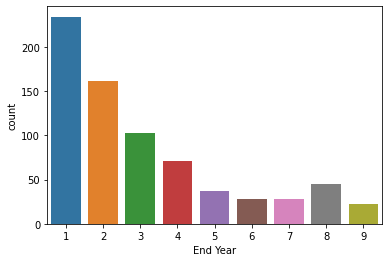

In [74]:
sns.countplot(id_freq_schools['End Year'], label='count')

In [75]:
# Select frequency that a school appears in either the top or bottom percentile of the highly impacted schools
# There should be a default selected. 

select_frequency = 5

# If school code frequency is >= 5 years, then they remain. Unless above variable is updated to a different number.   

for i in id_freq_schools.index:
  if id_freq_schools['End Year'][i] < select_frequency:
    id_freq_schools.drop([i], axis= 0, inplace=True)

freq_school_code = id_freq_schools.index.unique().sort_values()

In [76]:
freq_school_code

Int64Index([  6010,  11022,  11025,  21014,  21027,  26010,  35011,  35015,
             35065,  51080,
            ...
            501395, 505010, 525035, 567020, 571002, 571230, 585050, 585125,
            591061, 591062],
           dtype='int64', name='School Code', length=160)

In [77]:
# This is the detailed schools who are repeatedly in the top/bottom.
# Pulls all of their school data. 

ten_year_impacted = published_ky_df.iloc[0:0,:]

for code in freq_school_code:
  school_ten_year = published_ky_df[published_ky_df['School Code'] == code]
  ten_year_impacted = ten_year_impacted.append(school_ten_year)


In [78]:
ten_year_impacted.sort_values(by=['Money Difference per school'], inplace=True)

In [79]:
ten_year_impacted

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
5570,2012,275,Jefferson County,275620,Frederick Law Olmsted Academy North,34,Needs Improvement,"10,980.00","-666,200.00",-880.00,"10,097.00"
5199,2019,275,Jefferson County,275155,Marion C. Moore School,40,Needs Improvement,"14,030.00","-643,000.00",-290.00,"13,743.00"
4574,2015,275,Jefferson County,275033,Valley High,42,Needs Improvement,"10,270.00","-634,200.00",-450.00,"9,822.00"
5197,2017,275,Jefferson County,275155,Marion C. Moore School,45,Distinguished,"12,230.00","-621,500.00",-310.00,"11,921.00"
4571,2012,275,Jefferson County,275033,Valley High,31,Needs Improvement,"10,290.00","-551,700.00",-600.00,"9,685.00"
...,...,...,...,...,...,...,...,...,...,...,...
9573,2022,571,Warren County,571230,Greenwood High School,74,Distinguished,NaN,NaN,NaN,NaN
9657,2022,585,Webster County,585050,Dixon Elementary School,55,Proficient,NaN,NaN,NaN,NaN
9681,2022,585,Webster County,585125,Webster County Middle School,53,Proficient,NaN,NaN,NaN,NaN
9708,2022,591,Whitley County,591061,Whitley Central Intermediate School,75,Distinguished,NaN,NaN,NaN,NaN


# Projected AST scores

In [80]:
# Excluding the 2022 year so we can get the pre-covid trend. 

trends_df = predict_df[predict_df['End Year'] != 2022]
trends_df.reset_index(drop= True, inplace= True)

## Regression plots

In [81]:
def school_data(district, school):
  single_school_data = trends_df.query('`District` == @district and `School` == @school')
  sns.regplot(x = single_school_data['End Year'], y = single_school_data['Proficiency Rate'], fit_reg=True)
  plt.xlim(2012, 2020)
  plt.ylim(10, 110)
  plt.xlabel('Year')
  plt.ylabel('Proficiency Rate per school')
  plt.title('Pre-Covid Trend')
  plt.gca().legend(('Test Trend','Actual test scores'), loc='upper left')
  plt.show()
  

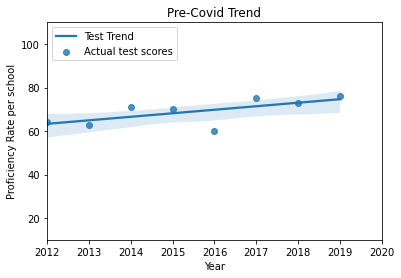

In [82]:
school_data('Woodford County', 'Northside Elementary School')

In [83]:
def predict_school(district, school):
  single_school_data = trends_df.query('`District` == @district and `School` == @school')
  sns.regplot(x = single_school_data['End Year'], 
              y = single_school_data['Proficiency Rate'], fit_reg=True)
  slope, intercept = np.polyfit(single_school_data['End Year'], single_school_data['Proficiency Rate'], 1)
  plt.xlim(2012, 2030)
  plt.ylim(10, 120)

  pred_2022 = predict_df[predict_df['End Year'] == 2022]
  pred_2022.set_index(['School Code'], inplace=True)
  x_pred = [2022,2023,2024,2025,2026,2027,2028,2029,2030]
  y_pred = []

  school_code = single_school_data['School Code'].unique()[0]
  covid_ast = pred_2022.at[school_code, 'Proficiency Rate']
  intercept = covid_ast - (slope * 2022)

  for year in x_pred:
    y = slope * year + intercept
    y_pred.append(y)

  plt.plot(x_pred, y_pred, linestyle='dashed') # The predicted trend
  plt.scatter(x_pred[0], y_pred[0], marker="o") # Making the actual point stand out
  plt.xlabel('Year')
  plt.ylabel('Proficiency Rate per school')
  plt.title(("%s \n Test Trends and Predictions"%school))
  plt.gca().legend(('Test Trend','Predicted Test Scores', 'Actual Test score'), loc='best')
  plt.show()
  
# Do I want to set aside the schools that have a negative or mostly horizontal slope ? 

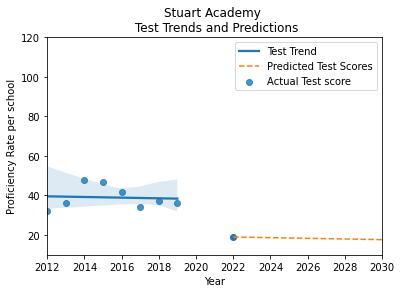

In [84]:
predict_school('Jefferson County', 'Stuart Academy')

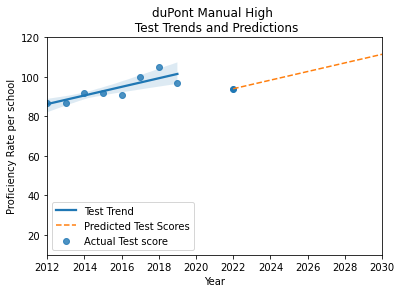

In [85]:
predict_school('Jefferson County', 'duPont Manual High')

# School Data Summarized

## Average School Spending

In [86]:
school_spending = predict_df.groupby(['School Code']).mean().loc[:,['Reported Spending per student', 
                                                                    'Money Difference per school',
                                                                    'Money Difference per student', 
                                                                    'Estimated Spending per student']]

school_spending.dropna(inplace=True) # Drops 13 schools

school_spending.columns =  ['Reported Spending based on district teacher experience', # Mandated reported average per student per year based on average teacher experience throughout the entire district
                            'Money Difference per school', # average per year
                            'Money Difference per student', # average per student per year
                            'Estimated Spending based on school teacher experience'] #  average per student per year


In [87]:
school_spending

,Reported Spending based on district teacher experience,Money Difference per school,Money Difference per student,Estimated Spending based on school teacher experience
School Code,,,,
1010,"9,355.00","-12,787.50",-17.50,"9,336.62"
1014,"8,621.25","-8,212.50",-21.25,"8,598.88"
1016,"9,621.25",637.50,0.00,"9,622.62"
1020,"12,950.00","22,300.00",40.00,"12,993.50"
5010,"11,740.00","134,762.50",147.50,"11,886.50"
...,...,...,...,...
601050,"10,725.00","70,762.50",136.25,"10,861.75"
601075,"12,065.00","-14,650.00",-30.00,"12,033.38"
601084,"9,492.50","28,962.50",23.75,"9,515.38"


## Test Scores with pivot table

In [88]:
pivot_df = predict_df.pivot(index=['School Code'], columns='End Year', values='Proficiency Rate')

In [89]:
# We want the pre-covid classifcation, not the post covid classfication

school_summary = trends_df.sort_values(by='End Year', ascending=False).loc[:,['District', 'School Code', 'School', 'Classification']]

school_summary.drop_duplicates(subset='School Code', inplace=True)

#Set index to school code
school_summary.set_index(['School Code'], inplace=True)

# Rename classification column to be more accurate
school_summary.columns = ['District', 'School', 'Pre-covid Classification']

In [90]:
# Join school summary data with the pivot_df

school_summary = school_summary.join(pivot_df, how='outer')

## Add type, title 1 status & locations

In [91]:
# Join with the school spending data. 
school_summary = school_summary.join(school_spending, how='outer')

In [92]:
# Drops the rows where 5 or more values are not missing
school_summary.dropna(axis=0, thresh=5, inplace=True) # This drops 13 schools

In [93]:
# Add in school locations
school_locations = pd.read_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/school_locations_2022.csv')

school_info = school_locations.loc[:,['School Code', 'School Type', 'Title I Status', 'Latitude', 'Longitude']]

school_info.set_index(['School Code'], inplace=True)

In [94]:
school_summary = school_summary.join(school_info, how='left')

## Correlations

In [95]:
# Converts & rounds to integers
def round_df_to_float(df, column_list):
  for column in column_list:
    df[column] = pd.to_numeric(df[column], errors='ignore')
    df = df.round({column:-1})
  return(df)

In [96]:
col_school = ['Reported Spending based on district teacher experience',
              'Money Difference per school', 
              'Money Difference per student', 
              'Estimated Spending based on school teacher experience']

In [97]:
school_summary = round_df_to_float(school_summary, col_school)

In [98]:
school_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 1010 to 601120
Data columns (total 20 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   District                                                1130 non-null   object 
 1   School                                                  1130 non-null   object 
 2   Pre-covid Classification                                1130 non-null   object 
 3   2012                                                    1069 non-null   float64
 4   2013                                                    1072 non-null   float64
 5   2014                                                    1080 non-null   float64
 6   2015                                                    1088 non-null   float64
 7   2016                                                    1091 non-null   float64
 8   2017                             

In [99]:
school_summary

,District,School,Pre-covid Classification,2012,2013,2014,2015,2016,2017,2018,2019,2022,Reported Spending based on district teacher experience,Money Difference per school,Money Difference per student,Estimated Spending based on school teacher experience,School Type,Title I Status,Latitude,Longitude
School Code,,,,,,,,,,,,,,,,,,,,
1010,Adair County,Adair County High School,Proficient,55.00,54.00,69.00,71.00,72.00,60.00,57.00,70.00,61.00,"9,360.00","-12,790.00",-20.00,"9,340.00",A1,Title 1 Eligible - Schoolwide School,37.11,-85.33
1014,Adair County,Adair County Middle School,Distinguished,48.00,53.00,62.00,63.00,68.00,65.00,73.00,68.00,55.00,"8,620.00","-8,210.00",-20.00,"8,600.00",A1,Title 1 Eligible - Schoolwide School,37.10,-85.32
1016,Adair County,Adair County Elementary School,Proficient,63.00,63.00,63.00,60.00,69.00,71.00,67.00,69.00,54.00,"9,620.00",640.00,0.00,"9,620.00",A1,Title 1 Eligible - Schoolwide School,37.11,-85.33
1020,Adair County,Adair County Primary Center,Proficient,NaN,NaN,NaN,NaN,NaN,NaN,67.00,69.00,54.00,"12,950.00","22,300.00",40.00,"12,990.00",A1,Title 1 Eligible - Schoolwide School,37.11,-85.33
5010,Allen County,Allen County Primary Center,Needs Improvement,50.00,59.00,70.00,68.00,71.00,76.00,75.00,65.00,55.00,"11,740.00","134,760.00",150.00,"11,890.00",A1,Title 1 Eligible - Schoolwide School,36.75,-86.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601050,Woodford County,Southside Elementary School,Distinguished,62.00,67.00,78.00,78.00,74.00,82.00,79.00,70.00,73.00,"10,720.00","70,760.00",140.00,"10,860.00",A1,Title 1 Eligible - Schoolwide School,38.04,-84.72
601075,Woodford County,Simmons Elementary School,Distinguished,54.00,55.00,68.00,64.00,71.00,76.00,80.00,68.00,69.00,"12,060.00","-14,650.00",-30.00,"12,030.00",A1,Title 1 Eligible - Schoolwide School,38.05,-84.75
601084,Woodford County,Woodford County High School,Distinguished,63.00,70.00,80.00,81.00,81.00,82.00,69.00,77.00,66.00,"9,490.00","28,960.00",20.00,"9,520.00",A1,Not a Title 1 School,38.06,-84.73


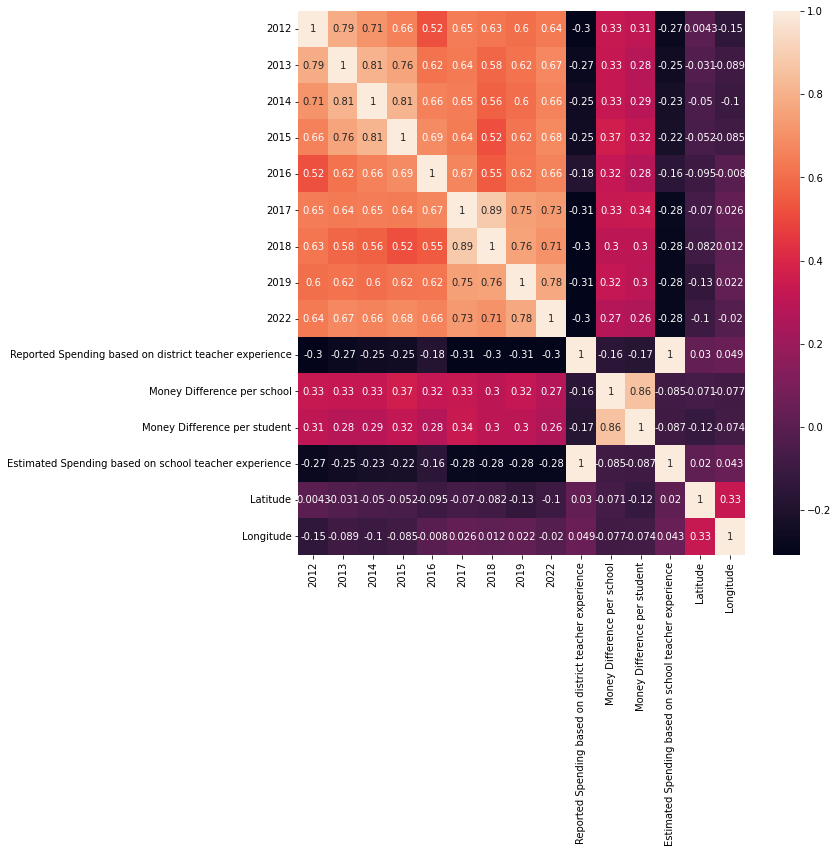

In [100]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(school_summary.corr(), annot=True)

# Aggregate District Data

In [101]:
agg_district_data = predict_df.groupby(['District', 'End Year']).agg({'Proficiency Rate': ['mean', 'min', 'max'],
                                      'Reported Spending per student': ['mean'],
                                      'Money Difference per school': ['min', 'max']
                                       })

agg_district_data.columns = ['Average Proficiency Score', 
                             'Minimum Proficiency Score',
                             'Maximum Proficiency Score',
                             'Average Reported Spending (per student)',
                             'Minimum Money Difference (estimated)',
                             'Maximum Money Difference (estimated)']

agg_district_data.reset_index(drop=False, inplace=True)

In [102]:
agg_district_data

,District,End Year,Average Proficiency Score,Minimum Proficiency Score,Maximum Proficiency Score,Average Reported Spending (per student),Minimum Money Difference (estimated),Maximum Money Difference (estimated)
0,Adair County,2012,55.33,48,63,"6,813.33","-55,700.00","-33,800.00"
1,Adair County,2013,56.67,53,63,"6,830.00","-37,000.00","-21,200.00"
2,Adair County,2014,64.67,62,69,"6,946.67","-13,100.00","-11,300.00"
3,Adair County,2015,64.67,60,71,"9,400.00","-42,100.00","24,800.00"
4,Adair County,2016,69.67,68,72,"9,900.00","-19,200.00","38,300.00"
...,...,...,...,...,...,...,...,...
1520,Woodford County,2016,73.20,60,81,"10,880.00","28,600.00","173,200.00"
1521,Woodford County,2017,81.00,75,90,"10,372.00","4,800.00","161,700.00"
1522,Woodford County,2018,77.40,69,86,"12,762.00","8,300.00","80,800.00"
1523,Woodford County,2019,71.60,67,77,"11,334.00","6,600.00","74,600.00"


# Highest Impacted Schools - Summary

In [103]:
# Publish highly impacted schools across multiple years. 


school_summary.loc[freq_school_code].sort_values(by='Money Difference per school')

,District,School,Pre-covid Classification,2012,2013,2014,2015,2016,2017,2018,2019,2022,Reported Spending based on district teacher experience,Money Difference per school,Money Difference per student,Estimated Spending based on school teacher experience,School Type,Title I Status,Latitude,Longitude
School Code,,,,,,,,,,,,,,,,,,,,
275155,Jefferson County,Marion C. Moore School,Needs Improvement,38.00,39.00,54.00,53.00,51.00,45.00,32.00,40.00,34.00,"10,500.00","-500,660.00",-260.00,"10,240.00",A1,Title 1 Eligible - Schoolwide School,38.14,-85.64
275033,Jefferson County,Valley High,Needs Improvement,31.00,39.00,55.00,42.00,42.00,29.00,27.00,42.00,46.00,"13,120.00","-460,280.00",-410.00,"12,710.00",A1,Title 1 Eligible - Schoolwide School,38.11,-85.87
275100,Jefferson County,Doss High,Needs Improvement,36.00,43.00,62.00,58.00,66.00,42.00,28.00,33.00,44.00,"12,410.00","-375,560.00",-390.00,"12,020.00",A1,Title 1 Eligible - Schoolwide School,38.15,-85.81
275335,Jefferson County,Iroquois High,Needs Improvement,34.00,40.00,58.00,56.00,58.00,30.00,18.00,20.00,26.00,"13,780.00","-371,980.00",-330.00,"13,450.00",A1,Title 1 Eligible - Schoolwide School,38.17,-85.78
275620,Jefferson County,Frederick Law Olmsted Academy North,Needs Improvement,34.00,34.00,48.00,46.00,49.00,37.00,36.00,35.00,24.00,"14,150.00","-343,650.00",-530.00,"13,620.00",A1,Title 1 Eligible - Schoolwide School,38.19,-85.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275018,Jefferson County,Atherton High,Distinguished,60.00,66.00,77.00,80.00,83.00,76.00,79.00,75.00,76.00,"10,400.00","563,120.00",420.00,"10,820.00",A1,Title 1 Eligible - No Program,38.21,-85.69
275007,Jefferson County,Eastern High,Distinguished,62.00,67.00,77.00,78.00,81.00,80.00,74.00,71.00,66.00,"9,640.00","595,800.00",300.00,"9,930.00",A1,Title 1 Eligible - No Program,38.24,-85.53
275105,Jefferson County,Ballard High,Distinguished,62.00,67.00,78.00,79.00,81.00,68.00,76.00,70.00,71.00,"9,640.00","619,380.00",330.00,"9,970.00",A1,Title 1 Eligible - No Program,38.28,-85.62


In [104]:
school_summary 

,District,School,Pre-covid Classification,2012,2013,2014,2015,2016,2017,2018,2019,2022,Reported Spending based on district teacher experience,Money Difference per school,Money Difference per student,Estimated Spending based on school teacher experience,School Type,Title I Status,Latitude,Longitude
School Code,,,,,,,,,,,,,,,,,,,,
1010,Adair County,Adair County High School,Proficient,55.00,54.00,69.00,71.00,72.00,60.00,57.00,70.00,61.00,"9,360.00","-12,790.00",-20.00,"9,340.00",A1,Title 1 Eligible - Schoolwide School,37.11,-85.33
1014,Adair County,Adair County Middle School,Distinguished,48.00,53.00,62.00,63.00,68.00,65.00,73.00,68.00,55.00,"8,620.00","-8,210.00",-20.00,"8,600.00",A1,Title 1 Eligible - Schoolwide School,37.10,-85.32
1016,Adair County,Adair County Elementary School,Proficient,63.00,63.00,63.00,60.00,69.00,71.00,67.00,69.00,54.00,"9,620.00",640.00,0.00,"9,620.00",A1,Title 1 Eligible - Schoolwide School,37.11,-85.33
1020,Adair County,Adair County Primary Center,Proficient,NaN,NaN,NaN,NaN,NaN,NaN,67.00,69.00,54.00,"12,950.00","22,300.00",40.00,"12,990.00",A1,Title 1 Eligible - Schoolwide School,37.11,-85.33
5010,Allen County,Allen County Primary Center,Needs Improvement,50.00,59.00,70.00,68.00,71.00,76.00,75.00,65.00,55.00,"11,740.00","134,760.00",150.00,"11,890.00",A1,Title 1 Eligible - Schoolwide School,36.75,-86.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601050,Woodford County,Southside Elementary School,Distinguished,62.00,67.00,78.00,78.00,74.00,82.00,79.00,70.00,73.00,"10,720.00","70,760.00",140.00,"10,860.00",A1,Title 1 Eligible - Schoolwide School,38.04,-84.72
601075,Woodford County,Simmons Elementary School,Distinguished,54.00,55.00,68.00,64.00,71.00,76.00,80.00,68.00,69.00,"12,060.00","-14,650.00",-30.00,"12,030.00",A1,Title 1 Eligible - Schoolwide School,38.05,-84.75
601084,Woodford County,Woodford County High School,Distinguished,63.00,70.00,80.00,81.00,81.00,82.00,69.00,77.00,66.00,"9,490.00","28,960.00",20.00,"9,520.00",A1,Not a Title 1 School,38.06,-84.73
